In [1]:
import numpy as np
import numpy.ma as ma
import glob
import xarray as xr
import sys
#import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib import rc
from mpl_toolkits.basemap import Basemap
%matplotlib inline  

In [2]:
root_folder  = '/work/mi19918/Projects/'
project_name = 'uTSS'

expid = 'Exp01.2'

fname = root_folder+project_name+'/'+expid+'/'+'uTSSm0_ous.nc'


In [3]:
chunks=(10000,10000)
xr_chunks={'node':chunks[-1]}

In [4]:
data = xr.open_dataset(fname,chunks=xr_chunks)
data['element_index'] -= 1

In [5]:
# constants
fzero = 9.5681e-5

In [6]:
def coriolis(lat):
     """Compute the Coriolis parameter for the given latitude:
     ``f = 2*omega*sin(lat)``, where omega is the angular velocity 
     of the Earth.
     
     Parameters
     ----------
     lat : array
       Latitude [degrees].
     """
     omega   = 7.2921159e-05  # angular velocity of the Earth [rad/s]
     return 2*omega*np.sin(lat/360.*2*np.pi)


In [7]:
def ev_g2c(lambdar, phi, lambda0, phi0):
     ''' Compute UTC location from lon, lat values   '''
     rad = np.pi/180.0
     rEarth = 6378206.4E0
     dlambda = rad * (lambdar - lambda0)                               
     dphi    = rad * (phi - phi0)                                     
     xa = rEarth*dlambda*np.cos(rad*phi0)                                     
     ya = rEarth*dphi      
 
     return xa,ya


In [8]:
dlon0 = np.mean(data.longitude)
dlat0 = np.mean(data.latitude)
fcor = coriolis(data.latitude)

In [17]:
import matplotlib as mpl
def shfn():
    ff = np.loadtxt('/users/home/mi19918/matlab/tools/jet4_python')
    cmap_needjet2= mpl.colors.LinearSegmentedColormap.from_list("my_colormap",ff, N=54, gamma=1.0)
    return cmap_needjet2

cmap_needjet2=shfn()

In [9]:
def compute_xshape_fc(y1, y2, y3, area):
    '''Compute x-derivative shape function values'''
    aji = 1.0/area
    b1 = (y2-y3)*aji
    b2 = (y3-y1)*aji
    b3 = (y1-y2)*aji
    return b1,b2,b3

In [10]:
def compute_yshape_fc(x1, x2, x3, area):
    '''Compute y-derivative shape function values'''
    aji = 1.0/area
    c1 = (x3-x2)*aji
    c2 = (x1-x3)*aji
    c3 = (x2-x1)*aji
    return c1,c2,c3

In [12]:
# compute shape functions
shapef = {}
x1tmp = data.longitude[data.element_index[:,0]]
y1tmp = data.latitude[data.element_index[:,0]]
x1,y1 = ev_g2c(x1tmp, y1tmp, dlon0, dlat0)
x2tmp = data.longitude[data.element_index[:,1]]
y2tmp = data.latitude[data.element_index[:,1]]
x2,y2 = ev_g2c(x2tmp, y2tmp, dlon0, dlat0)
x3tmp = data.longitude[data.element_index[:,2]]
y3tmp = data.latitude[data.element_index[:,2]]
x3,y3 = ev_g2c(x3tmp, y3tmp, dlon0, dlat0)
area = (x2-x1)*(y3-y1) - (x3-x1)*(y2-y1)

b1,b2,b3 = compute_xshape_fc(y1, y2, y3, area)
c1,c2,c3 = compute_xshape_fc(y1, y2, y3, area)

dnm = [b1,b2,b3]
shapef.setdefault('xderiv',[]).append(dnm)
dnm = [c1,c2,c3]
shapef.setdefault('yderiv',[]).append(dnm)

In [13]:
# velocity time,node,level indexing
varu = data.u_velocity[-1,:,0]
varv = data.v_velocity[-1,:,0]


In [14]:
# compute relative vorticity 
u1 = varu[data.element_index[:,0]]
u2 = varu[data.element_index[:,1]]
u3 = varu[data.element_index[:,2]]
v1 = varv[data.element_index[:,0]]
v2 = varv[data.element_index[:,1]]
v3 = varv[data.element_index[:,2]]

# relative vorticity ksi = vx-uy 
vx = v1*shapef['xderiv'][0][0] 
vx = vx+v2*shapef['xderiv'][0][1] 
vx = vx+v3*shapef['xderiv'][0][2] 
 
uy = u1*shapef['yderiv'][0][0] 
uy = uy+u2*shapef['yderiv'][0][1] 
uy = uy+u3*shapef['yderiv'][0][2] 
 
ksi = vx-uy

In [15]:
# compute ksi at node points
ksinode=np.zeros(data.node.shape)

ksinode[data.element_index[data.element,0]]=ksinode[data.element_index[data.element,0]]+area*ksi[data.element]
ksinode[data.element_index[data.element,1]]=ksinode[data.element_index[data.element,1]]+area*ksi[data.element]
ksinode[data.element_index[data.element,2]]=ksinode[data.element_index[data.element,2]]+area*ksi[data.element]

weight=np.zeros(data.node.shape)
weight[data.element_index[data.element,0]]=weight[data.element_index[data.element,0]]+area
weight[data.element_index[data.element,1]]=weight[data.element_index[data.element,1]]+area
weight[data.element_index[data.element,2]]=weight[data.element_index[data.element,2]]+area

ksinode=ksinode/weight


/users/home/mi19918/.conda/envs/uTSS/lib/python2.7/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


/users/home/mi19918/.conda/envs/uTSS/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


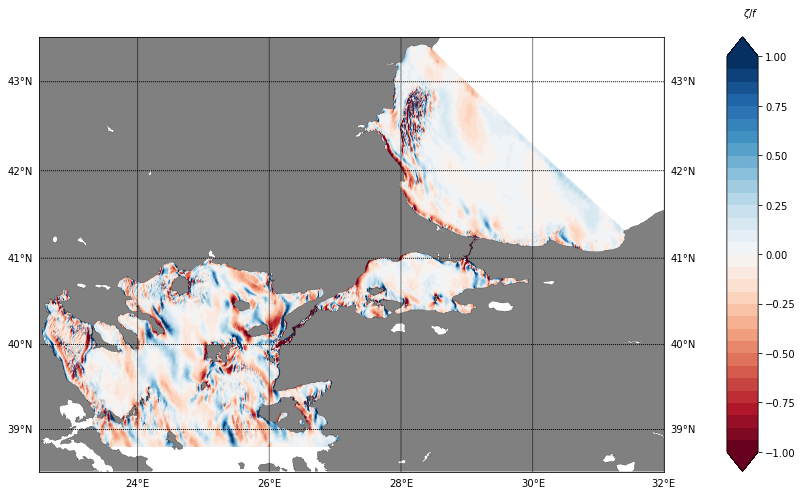

In [16]:
plt.ion()
plt.figure(figsize=(16,8))
m = Basemap(llcrnrlon=22.5,llcrnrlat=38.5,urcrnrlon=32.,urcrnrlat=43.5,\
             rsphere=(6378137.00,6356752.3142),\
             resolution='h',projection='merc',\
             lat_0=40.,lon_0=20.,lat_ts=20.)
 
m.drawcoastlines(linewidth=0.2)
m.fillcontinents(color='grey')
m.drawparallels(np.arange(38,44,1),labels=[1,1,0,0])
m.drawmeridians(np.arange(22,33,2),labels=[0,0,0,1])

longitude,latitude = m(np.copy(data.longitude),np.copy(data.latitude))
 
im1=plt.tripcolor(longitude,latitude,data.element_index,
                 ksinode/fcor,cmap=plt.cm.get_cmap('RdBu', 32),vmin=-1,vmax=1,shading='gouraud')

cb = m.colorbar(im1,"right", size="5%", pad="10%",ticks=[-1,-0.75,-0.5, -0.25,
                                                          0, 0.25, 0.5, 0.75, 1],
               extend='both') # pad is the distance between colorbar and figure
cb.set_label('$\zeta/f$',rotation=0,y=1.07,labelpad=-45)
plt.show()

In [ ]:
plt.ion()
plt.figure(figsize=(16,8))
m = Basemap(llcrnrlon=22.5,llcrnrlat=38.5,urcrnrlon=32.,urcrnrlat=43.5,\
             rsphere=(6378137.00,6356752.3142),\
             resolution='h',projection='merc',\
             lat_0=40.,lon_0=20.,lat_ts=20.)
 
m.drawcoastlines(linewidth=0.2)
m.fillcontinents(color='grey')
m.drawparallels(np.arange(38,44,1),labels=[1,1,0,0])
m.drawmeridians(np.arange(22,33,2),labels=[0,0,0,1])
 
im1=plt.tripcolor(longitude,latitude,data.element_index,
                 data.total_depth,cmap='gist_ncar',vmin=2,vmax=2100,shading='gouraud')

cb = m.colorbar(im1,"right", size="5%", pad="10%",
               extend='max') # pad is the distance between colorbar and figure
#cb.set_label('$[m]]$',rotation=0,y=1.07,labelpad=-45)
plt.show()

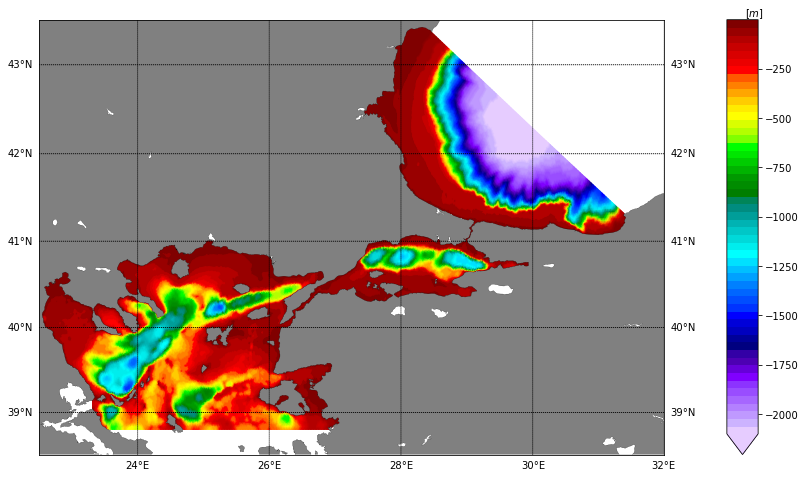

In [18]:
plt.ion()
plt.figure(figsize=(16,8))
m = Basemap(llcrnrlon=22.5,llcrnrlat=38.5,urcrnrlon=32.,urcrnrlat=43.5,\
             rsphere=(6378137.00,6356752.3142),\
             resolution='h',projection='merc',\
             lat_0=40.,lon_0=20.,lat_ts=20.)
 
m.drawcoastlines(linewidth=0.2)
m.fillcontinents(color='grey')
m.drawparallels(np.arange(38,44,1),labels=[1,1,0,0])
m.drawmeridians(np.arange(22,33,2),labels=[0,0,0,1])
 
im1=plt.tripcolor(longitude,latitude,data.element_index,
                 -data.total_depth,cmap=cmap_needjet2,vmin=-2100,vmax=-2,shading='gouraud')

cb = m.colorbar(im1,"right", size="5%", pad="10%",
               extend='min') # pad is the distance between colorbar and figure
cb.set_label('$[m]$',rotation=0,y=1.03,labelpad=-45)
plt.savefig('paperfigs/uTSS_bathy.png', bbox_inches='tight',format='png',dpi=300)